# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [1]:
!nvidia-smi

Mon Aug 22 04:33:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   45C    P0    59W / 150W |      0MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Завершить все процессы, использующие ГПУ в нашей ОС
!fuser -k /dev/nvidia[0]

In [3]:
import os

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision.models as models
from PIL import Image
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms


## The Dataset 💿



In [4]:
class RegressionDataset(Dataset):
    """
    Датасет с картинками, который производит изменения размера картинок,
    аугментации и преобразование в тензоры PyTorch
    """
    def __init__(self, img_paths, target, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = img_paths
        
        # изменяем размер картинок датасета на указанный
        self.rescale_size = rescale_size
        
        # режим работы
        self.mode = mode
        self.available_modes = ['train', 'val', 'test']

        if self.mode not in self.available_modes:
            print(f"{self.mode} is not correct; correct modes: {self.available_modes}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.target = target
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        
            # transforms.Normalize делается для того, чтобы подогнать наши 
            # данные под данные на которых были предобучены наши нейронные сети
            # из torchvision.models они были обученные  на наборе данных 
            # ImageNet в документации по самому torchvision.models так же 
            # сказано https://pytorch.org/docs/stable/torchvision/models.html

            # All pre-trained models expect input images normalized in the same way,
            # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
            # where H and W are expected to be at least 224. The images have to be
            # loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406]
            # and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
            
            # И ниже код от самих разработчиков PyTorch
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=self.rescale_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        #x = np.array(x / 255, dtype='float32') *см. примечание ниже

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обучающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            y = self.target[index].item()

            return x, y

In [5]:
class RegressionDataModule(pl.LightningDataModule):
    def __init__(self, df_train_all, img_path_col, target_col, df_test, val_size, rescale_size, batch_size, num_workers):
        super().__init__()

        # задаем параметры даталоадера
        self.rescale_size = rescale_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # задаем данные датасета
        train, val = train_test_split(df_train_all,
                                      test_size=val_size,
                                      random_state=42,
                                      stratify=df_train_all[target_col].values)

        train_paths = train[img_path_col].values
        train_target = train[target_col].values
        self.val_paths = val[img_path_col].values
        self.val_target = val[target_col].values
        test_paths = df_test[img_path_col].values

        self.train = RegressionDataset(train_paths,
                                       train_target,
                                       mode='train',
                                       rescale_size=self.rescale_size)

        self.val = RegressionDataset(self.val_paths,
                                     self.val_target,
                                     mode='val',
                                     rescale_size=self.rescale_size)

        self.test = RegressionDataset(test_paths,
                                      None,
                                      mode='test',
                                      rescale_size=self.rescale_size)

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_by_val_dataloader(self):
        test_val = RegressionDataset(self.val_paths,
                                     None,
                                     mode='test',
                                     rescale_size=self.rescale_size)

        return DataLoader(test_val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


## Загрузка данных

In [6]:
train_all = pd.read_csv('data/gen.csv')
test = pd.read_csv('data/test.csv')

In [7]:
def df_change_paths(df, path, path_col):
    df[path_col] =  path + '/' + df[path_col]

In [8]:
# меняем пути у train и test
df_change_paths(test, path = 'data', path_col = 'img_path')

In [9]:
train_all

,img_path,label
0,data/gen_data/1.png,1
1,data/gen_data/2.png,5
2,data/gen_data/3.png,4
3,data/gen_data/4.png,6
4,data/gen_data/5.png,6
...,...,...
9995,data/gen_data/9996.png,4
9996,data/gen_data/9997.png,3
9997,data/gen_data/9998.png,3
9998,data/gen_data/9999.png,4


In [10]:
test

,img_path
0,data/test_data/1.png
1,data/test_data/2.png
2,data/test_data/3.png
3,data/test_data/4.png
4,data/test_data/5.png
...,...
5995,data/test_data/5996.png
5996,data/test_data/5997.png
5997,data/test_data/5998.png
5998,data/test_data/5999.png


## LightingModule - Define the System

Let us look at the model definition to see how transfer learning can be used with PyTorch Lightning.
In the `LitModel` class, we can use the pre-trained model provided by Torchvision as a feature extractor for our classification model. Here we are using ResNet-18. A list of pre-trained models provided by PyTorch Lightning can be found here.
- When `pretrained=True`, we use the pre-trained weights; otherwise, the weights are initialized randomly.
- If `.eval()` is used, then the layers are frozen. 
- A single `Linear` layer is used as the output layer. We can have multiple layers stacked over the `feature_extractor`.

Setting the `transfer` argument to `True` will enable transfer learning.

In [11]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, learning_rate=1e-4, transfer=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.step = 0

        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet50(pretrained=transfer)

        if transfer:
            self.set_transfer()

        n_sizes = self._get_conv_output(input_shape)

        self.regressor = nn.Linear(n_sizes, 1)

        self.criterion = nn.functional.mse_loss
        self.metric = nn.functional.mse_loss

    def set_transfer(self):
        # layers are frozen by using eval()
        self.feature_extractor.eval()
        # freeze params
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
            
    def set_trainable(self):
        # layers are frozen by using eval()
        self.feature_extractor.train()
        # freeze params
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

    # returns the size of the output tensor going into the Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x

    # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)

        return x

    def training_step(self, batch):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        out, gt = out.float(), gt.float().unsqueeze(1)

        loss = self.criterion(out, gt)

        mse = self.metric(out, gt)

        self.step += 1

        self.log("train_loss", loss)
        self.log("train_mse", mse)
        self.log("train_step", self.step)

        return loss

    def validation_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        out, gt = out.float(), gt.float().unsqueeze(1)
        loss = self.criterion(out, gt)

        self.log("val_loss", loss)

        mse = self.metric(out, gt)
        self.log("val_mse", mse)

        return loss

    def predict_step(self, batch, batch_idx):
        return self(batch).tolist()

    def test_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        out, gt = out.float(), gt.float().unsqueeze(1)
        loss = self.criterion(out, gt)

        return {"loss": loss, "outputs": out, "gt": gt}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['loss'].float() for x in outputs]).mean()
        output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

        gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

        self.log("test_loss", loss)
        mse = self.metric(output, gts)
        self.log("test_mse", mse)

        self.test_gts = gts
        self.test_output = output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [12]:
transfer_flag=False

In [13]:
# создаем загрузчик данных
dm = RegressionDataModule(df_train_all=train_all,
                          img_path_col='img_path',
                          target_col='label',
                          df_test=test,
                          val_size=0.2,
                          rescale_size=(224, 224),
                          batch_size=64,
                          num_workers=12)

In [14]:
model = LitModel((3, 224, 224), transfer=transfer_flag)
trainer = pl.Trainer(accelerator="gpu", log_every_n_steps=10)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
`Trainer.fit` stopped: `max_steps=84` reached.
LR finder stopped early after 84 steps due to diverging loss.
Restoring states from the checkpoint path at /home/admin-gpu/Downloads/MADE_2022_contest_2/.lr_find_f39fddee-7b09-4015-ac60-4d7bd1b32c23.ckpt


In [16]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

1.3182567385564076e-05

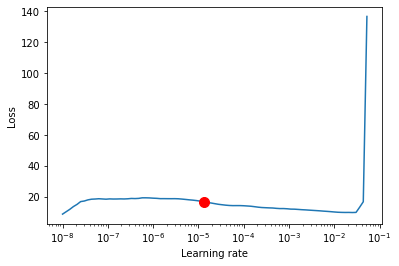

In [17]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

In [18]:
# зададим новый Lr модели
new_lr = 0.1**5
new_lr

1.0000000000000003e-05

### Можем найти максимально возможный батч который влезет на нашу ГПУ

Не оптимальный размер батча для обучения, а именно максимально возможный на нашем оборудовании.

In [19]:
# model = LitModel((3, 224, 224), transfer=transfer_flag, learning_rate=new_lr)
# trainer = pl.Trainer(accelerator="gpu", auto_scale_batch_size="binsearch")

In [20]:
# call tune to find the batch size
# trainer.tune(model, dm)

### Непосредственно обучение модели

In [19]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_mse", patience=10, verbose=False, mode="min")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


### Претрейн регрессора

In [20]:
# начинаем обучение модели

model = LitModel((3, 224, 224), transfer=True, learning_rate=0.1**3)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     max_epochs=15,
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, dm)

Missing logger folder: /home/admin-gpu/Downloads/MADE_2022_contest_2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 25.6 M
1 | regressor         | Linear | 1.0 K 
---------------------------------------------
1.0 K     Trainable params
25.6 M    Non-trainable params
25.6 M    Total params
102.232   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [22]:
model = model.load_from_checkpoint("models_check/gen/check_point-epoch=12-val_loss=1.99.ckpt")

### Тренеровка всей модели

In [23]:
# делаем обучаемой всю модель!
model.set_trainable()
model.learning_rate = 0.1**5

In [24]:
model.learning_rate

1.0000000000000003e-05

In [25]:
# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, dm)

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/admin-gpu/Downloads/MADE_2022_contest_2/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 25.6 M
1 | regressor         | Linear | 1.0 K 
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.232   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
model = model.load_from_checkpoint("lightning_logs/version_0/checkpoints/check_point-epoch=06-val_loss=1.53.ckpt")

Протестируем полученную модель

In [31]:
# можем проверить на тестовой части (подсунув вместо теста val)
# trainer.test(model, dm.val_dataloader())

In [32]:
# можем проверить на val части датасета
trainer.validate(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.5275959968566895
         val_mse            1.5275959968566895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.5275959968566895, 'val_mse': 1.5275959968566895}]

## Загрузим желаемый чекпоинт

In [33]:
# disable randomness, dropout, etc...
model.eval();

## Сделаем предсказание

### Сделаем предсказание на val

Проверим, что функции предсказания работаю корректно.
И что мы получаем тот же самый результат по метрике MSE, что и раньше.

In [34]:
# predict with the model
preds = trainer.predict(model, dm.test_by_val_dataloader())


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 125it [00:00, ?it/s]

In [35]:
y_preds = []
for sublist in preds:
    for item in sublist:
        y_preds.append(item[0])
        
y_preds = np.array(y_preds)

In [36]:
y_true = dm.val_target

In [37]:
# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()

In [38]:
# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_true, y_preds)}")
print(f"MAE = {mae(y_true, y_preds)}")

MSE = 1.5275959027536172
MAE = 0.9666769036613405


### Сделаем предсказание непосредственно на тесте

In [39]:
# predict with the model
preds = trainer.predict(model, dm.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 125it [00:00, ?it/s]

In [40]:
y_preds = []
for sublist in preds:
    for item in sublist:
        y_preds.append(item[0])
        
y_preds = np.array(y_preds)

In [41]:
y_preds

array([3.89724588, 8.35315609, 1.23029971, ..., 8.64776897, 4.31859064,
       1.17475533])

# публикуем сабмит

In [42]:
submission = pd.read_csv('data/sample_submission.csv')

In [43]:
submission

,label
0,0
1,0
2,0
3,0
4,0
...,...
5995,0
5996,0
5997,0
5998,0


In [44]:
submission['label'] = y_preds


In [46]:
submission

,label
0,3.897246
1,8.353156
2,1.230300
3,5.354795
4,5.307918
...,...
5995,9.745829
5996,7.859225
5997,8.647769
5998,4.318591


In [47]:
submission_path = 'submission/PyTorchLighnting_Resnet50_gen.csv'

In [48]:
submission.to_csv(submission_path, index=False)

## Conclusion

I will encourage you to play with the code and train an image classifier with a dataset of your choice from scratch and using transfer learning. 


To learn more about transfer learning check out these resources:
- [Gotchas of transfer learning for image classification](https://docs.google.com/presentation/d/1s29WOQoQvBD5KoPUzE5TPcavjqno8ZgnZaSljHGGHVU/edit?usp=sharing) by Sayak Paul.
- [Transfer Learning with Keras and Deep Learning by PyImageSearch.](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/) by Sebastian Ruder.





